In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import copy
import os
# Seed 설정 --> 코드를 돌릴때 random값을 동일하게 해주기 위해
random.seed(10)
np.random.seed(123)

# GPU사용을 위한 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 모델 파라미터 설정
config = {'Cifar10_stats': [[0.49139965, 0.48215845, 0.4465309],
                            [0.20220213, 0.19931543, 0.20086348]],
          'batch_size'  : 64,
          'worker'      : 2,
          'epochs'      : 10,
          'momentum'    : 0.9,
          'wd_decay'    : 0.0005,
          'Adam_lr'     : 0.0005,
          'SGD_lr'      : 0.001,
          'lambda'      : 1,
          'T'   : 5,
          }

Teacher_PATH="/content/drive/MyDrive/Colab Notebooks/자기주도연구1/DGKD_Models/Teacher"


cpu


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transforms.ToTensor())
print(f"Trainset 개수: {len(trainset)}, Testset 개수: {len(testset)}")



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Trainset 개수: 50000, Testset 개수: 10000


In [ ]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in trainset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in trainset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

In [ ]:
print("CIFAR10_MEAN:",train_meanR, train_meanG, train_meanB) # Cifar10_stats -> mean
print("CIFAR10_STD:",train_stdR, train_stdG, train_stdB) # Cifar10_stats-> std

CIFAR10_MEAN: 0.49139965 0.48215845 0.4465309
CIFAR10_STD: 0.20220213 0.19931543 0.20086348


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=16),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

test_transforms = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(*config['Cifar10_stats']), # mean = Cifar10_stats[0], std = Cifar10_stats[1]
])

# apply transform
trainset.transform = train_transforms
testset.transform = test_transforms

# Data Loader
trainloader = DataLoader(trainset, batch_size = config['batch_size'], shuffle = True, num_workers = config['worker'])

testloader = DataLoader(testset, batch_size = config['batch_size'], shuffle = False, num_workers = config['worker'])

# Class_name 저장
with open('./data/cifar-10-batches-py/batches.meta', 'rb') as f:
    batches_meta = pickle.load(f, encoding = 'latin1')
classes_name = list(batches_meta[sorted(list(batches_meta.keys()))[0]]) # airplane, automobile, ..., truck
print(classes_name)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


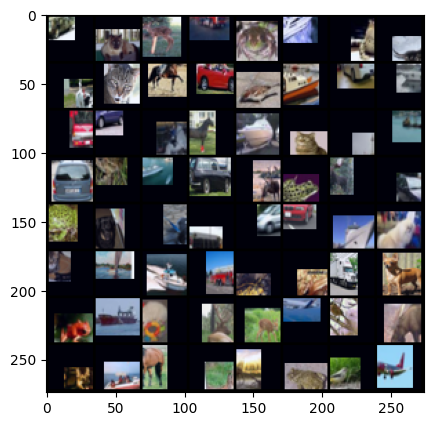

1: automobile	2: cat  	3: deer  	4: truck  	5: frog  	6: ship  	7: frog  	8: cat
9: dog  	10: cat  	11: horse  	12: automobile	13: bird  	14: ship  	15: automobile	16: ship
17: truck  	18: automobile	19: horse  	20: horse  	21: ship  	22: cat  	23: ship  	24: ship
25: automobile	26: frog  	27: ship  	28: automobile	29: deer  	30: frog  	31: deer  	32: automobile
33: frog  	34: dog  	35: dog  	36: truck  	37: automobile	38: automobile	39: ship  	40: dog
41: cat  	42: ship  	43: ship  	44: truck  	45: frog  	46: frog  	47: truck  	48: dog
49: frog  	50: ship  	51: dog  	52: deer  	53: deer  	54: airplane	55: bird  	56: deer
57: dog  	58: ship  	59: horse  	60: deer  	61: deer  	62: frog  	63: bird  	64: airplane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# trainloader의 이미지 확인
dataiter = iter(trainloader)
images, labels = next(dataiter)
fig = plt.figure(figsize = (15, 5), dpi = 100)
ax = fig.add_subplot(1,1,1)
ax.imshow(torchvision.utils.make_grid(images, normalize = True).permute(1, 2, 0))
plt.show()

# 해당 이미지의 label확인
for i in range(len(images)):
    if (i+1)%8==0:
        print(f'{i+1}: {classes_name[labels[i]]}', end = '\n')
    else:
        if len(classes_name[labels[i]]) >= 6:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '\t')
        else:
            print(f'{i+1}: {classes_name[labels[i]]}', end = '  \t')

In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    model = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return model


def conv1x1(in_channels, out_channels, stride=1):
    model = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return model

class Teacher(nn.Module):

    def __init__(self ,num_classes=10):
        super(Teacher, self).__init__()

        self.layer1=conv3x3(3,8)
        self.layer2=conv3x3(8,8)
        self.layer3=conv3x3(8,16)

        self.layer4=conv3x3(16,16)
        self.layer5=conv3x3(16,16)
        self.layer6=conv3x3(16,32)

        self.layer7=conv3x3(32,64)
        self.layer8=conv3x3(64,64)
        self.layer9=conv3x3(64,128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(2048, num_classes)

        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.pool(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class TA_8(nn.Module):

    def __init__(self ,num_classes=10):
        super(TA_8, self).__init__()

        self.layer1=conv3x3(3,8)
        self.layer2=conv3x3(8,16)
        self.layer3=conv3x3(16,16)

        self.layer4=conv3x3(16,32)
        self.layer5=conv3x3(32,32)
        self.layer6=conv3x3(32,64)

        self.layer7=conv3x3(64,64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(1024, num_classes)

        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.pool(x)
        x = self.layer7(x)

        x = self.pool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)

        return x

class TA_6(nn.Module):

    def __init__(self ,num_classes=10):
        super(TA_6, self).__init__()

        self.layer1=conv3x3(3,8)
        self.layer2=conv3x3(8,16)
        self.layer3=conv3x3(16,16)
        
        self.layer4=conv3x3(16,32)
        self.layer5=conv3x3(32,64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(4096, num_classes)

        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = self.layer4(x)
        x = self.layer5(x)



        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class TA_4(nn.Module):

    def __init__(self ,num_classes=10):
        super(TA_4, self).__init__()

        self.layer1=conv3x3(3,8)

        self.layer2=conv3x3(8,16)
        self.layer3=conv3x3(16,16)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(4096, num_classes)

        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
class Student(nn.Module):

    def __init__(self, num_classes=10):
        super(Student, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(1024, num_classes)


    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

Teacher=Teacher().to(device)
Student=Student().to(device)
Student2=Student().to(device)
#Teacher.load_state_dict(torch.load('/content/models/teacher_weights.pt'))
TA_8=TA_8().to(device)
TA_6=TA_6().to(device)
TA_4=TA_4().to(device)

Teacher_opt = optim.SGD(Teacher.parameters(),lr=config['SGD_lr'],momentum=config['momentum'])
Student_opt=optim.SGD(Student.parameters(),lr=config['SGD_lr'],momentum=config['momentum'])


#print(Teacher)
summary(Teacher, (3,32,32)) # (model, input_size)
summary(TA_8, (3,32,32)) # (model, input_size)
summary(TA_6, (3,32,32)) # (model, input_size)
summary(TA_4, (3,32,32)) # (model, input_size)
summary(Student, (3,32,32)) 

TypeError: ignored

In [ ]:
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

Teacher.apply(initialize_weights);
Student.apply(initialize_weights)

In [ ]:
def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(y/T,dim = 1), 
                                               F.softmax(teacher_scores/T,dim = 1)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)


def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects
loss_func = nn.CrossEntropyLoss()

def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=Student_opt):
    loss_b = loss_fn(output, target, teacher_output, T=5.0, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


In [ ]:
Teacher_train_loss=[]
Teacher_train_acc=[]

Student_train_loss=[]
Student_train_acc=[]

In [ ]:
def graph(loss_history,metric_history):
    num_epochs=len(loss_history)
    plt.title('Train-Val Loss')
    plt.plot(range(1, num_epochs+1), loss_history['train'], label='train')
    plt.plot(range(1, num_epochs+1), loss_history['val'], label='val')
    plt.ylabel('Loss')
    plt.xlabel('Training Epochs')
    plt.legend()
    plt.show()
    num_epochs=len(metric_history)
    plt.title('Train-Val Accuracy')
    plt.plot(range(1, num_epochs+1), metric_history['train'], label='train')
    plt.plot(range(1, num_epochs+1), metric_history['val'], label='val')
    plt.ylabel('Accuracy')
    plt.xlabel('Training Epochs')
    plt.legend()
    plt.show()

### Teacher 학습

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(data.shape,target.shape)
        data, target = data.to(device), target.to(device)
       
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % config['batch_size'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        Teacher_train_loss.append(loss.item()/len(trainloader))

## Validation set 으로 테스트하기

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    best_acc = 0
    best_f1 = 0
    best_acc_model = None 
    best_f1_model = None
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}


current_loss=0
last_loss = 100
patience = 5
triggertimes = 0
for epoch in range(1, config['epochs'] + 1):
    train(Teacher, trainloader, Teacher_opt, epoch)
    test_loss, test_accuracy = evaluate(Teacher, testloader)
    current_loss=test_loss
    print('[{}] Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))
    
    if current_loss > last_loss:
          trigger_times += 1
          print('Trigger Times:', trigger_times)

          if trigger_times >= patience:
              print('Early stopping!\nStart to test process.')
              break

    else:
          print('trigger times: 0')
          trigger_times = 0

    last_loss = current_loss
 

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.709890
Train Epoch: 1 [4096/50000 (8%)]	Loss: 2.188533
Train Epoch: 1 [8192/50000 (16%)]	Loss: 2.051682
Train Epoch: 1 [12288/50000 (25%)]	Loss: 2.284297
Train Epoch: 1 [16384/50000 (33%)]	Loss: 2.019500
Train Epoch: 1 [20480/50000 (41%)]	Loss: 2.043038
Train Epoch: 1 [24576/50000 (49%)]	Loss: 1.924375
Train Epoch: 1 [28672/50000 (57%)]	Loss: 1.803690
Train Epoch: 1 [32768/50000 (65%)]	Loss: 1.830850
Train Epoch: 1 [36864/50000 (74%)]	Loss: 1.853257
Train Epoch: 1 [40960/50000 (82%)]	Loss: 1.740692
Train Epoch: 1 [45056/50000 (90%)]	Loss: 1.879624
Train Epoch: 1 [49152/50000 (98%)]	Loss: 1.893082
[1] Validation Loss: 1.8597, Accuracy: 37.01%
trigger times: 0
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.888395
Train Epoch: 2 [4096/50000 (8%)]	Loss: 1.652547
Train Epoch: 2 [8192/50000 (16%)]	Loss: 1.804806
Train Epoch: 2 [12288/50000 (25%)]	Loss: 1.731972
Train Epoch: 2 [16384/50000 (33%)]	Loss: 1.671160
Train Epoch: 2 [20480/50000 (41%)]	Loss: 1.550308
Tra

###Student 학습

In [ ]:
current_loss=0
last_loss = 100
patience = 5
triggertimes = 0
for epoch in range(1, config['epochs'] + 1):
    train(Student2, trainloader, Student_opt, epoch)
    test_loss, test_accuracy = evaluate(Student2, testloader)
    current_loss=test_loss
    print('[{}] Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))
    
    if current_loss > last_loss:
          trigger_times += 1
          print('Trigger Times:', trigger_times)

          if trigger_times >= patience:
              print('Early stopping!\nStart to test process.')
              break

    else:
          print('trigger times: 0')
          trigger_times = 0

    last_loss = current_loss

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.662775
Train Epoch: 1 [4096/50000 (8%)]	Loss: 2.098850
Train Epoch: 1 [8192/50000 (16%)]	Loss: 2.137788
Train Epoch: 1 [12288/50000 (25%)]	Loss: 2.043588
Train Epoch: 1 [16384/50000 (33%)]	Loss: 2.085669
Train Epoch: 1 [20480/50000 (41%)]	Loss: 2.106783
Train Epoch: 1 [24576/50000 (49%)]	Loss: 1.989592
Train Epoch: 1 [28672/50000 (57%)]	Loss: 1.885922
Train Epoch: 1 [32768/50000 (65%)]	Loss: 1.927623
Train Epoch: 1 [36864/50000 (74%)]	Loss: 1.796257
Train Epoch: 1 [40960/50000 (82%)]	Loss: 1.863709
Train Epoch: 1 [45056/50000 (90%)]	Loss: 1.888183
Train Epoch: 1 [49152/50000 (98%)]	Loss: 1.828565
[1] Validation Loss: 1.9174, Accuracy: 31.41%
trigger times: 0
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.087075
Train Epoch: 2 [4096/50000 (8%)]	Loss: 1.959551
Train Epoch: 2 [8192/50000 (16%)]	Loss: 1.843840
Train Epoch: 2 [12288/50000 (25%)]	Loss: 1.961570
Train Epoch: 2 [16384/50000 (33%)]	Loss: 1.888656
Train Epoch: 2 [20480/50000 (41%)]	Loss: 1.641799
Tra

#Save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

T_PATH='/content/drive/MyDrive/Colab Notebooks/자기주도연구1/Models/Teacher/T_Model'
S_PATH='/content/drive/MyDrive/Colab Notebooks/자기주도연구1/Models/Student/S_Model'
Plane_PATH='/content/drive/MyDrive/Colab Notebooks/자기주도연구1/Models/Plane/P_Model'
TAKD_PATH='/content/drive/MyDrive/Colab Notebooks/자기주도연구1/Models/TAKD/TAKD_Model'

torch.save(Teacher.state_dict(), T_PATH)
torch.save(Student.state_dict(), S_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Hinton Loss

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(Student_opt, mode='min', factor=0.1, patience=10)

num_epochs= 10

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

T_loss_history={'train': [], 'val': []}
T_metric_history={'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = config['SGD_lr']
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    Student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(trainloader.dataset)

    for xb, yb in trainloader:
        xb = xb.to(device)
        yb = yb.to(device)

        output = Student(xb)
        teacher_output = Teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=Student_opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    Student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(Student, loss_func, testloader)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    lr_scheduler.step(val_loss)
    print('Teacher->Student')
    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('')


    

    lr_scheduler.step(val_loss)
    print('Student->Teacher')
    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/9, current lr= 0.001
Teacher->Student
train loss: 0.029847, val loss: 0.026840, accuracy: 45.11, time: 1.8036 min

Student->Teacher
train loss: 0.029847, val loss: 0.026840, accuracy: 45.11, time: 1.8036 min
----------
Epoch 1/9, current lr= 0.001
Teacher->Student
train loss: 0.029909, val loss: 0.026492, accuracy: 45.64, time: 3.5555 min

Student->Teacher
train loss: 0.029909, val loss: 0.026492, accuracy: 45.64, time: 3.5555 min
----------
Epoch 2/9, current lr= 0.001
Teacher->Student
train loss: 0.029770, val loss: 0.026227, accuracy: 45.78, time: 5.3038 min

Student->Teacher
train loss: 0.029770, val loss: 0.026227, accuracy: 45.78, time: 5.3038 min
----------
Epoch 3/9, current lr= 0.001
Teacher->Student
train loss: 0.029688, val loss: 0.026394, accuracy: 45.69, time: 7.0890 min

Student->Teacher
train loss: 0.029688, val loss: 0.026394, accuracy: 45.69, time: 7.0890 min
----------
Epoch 4/9, current lr= 0.001
Teacher->Student
train loss: 0.029623, val loss: 0.026177, accu

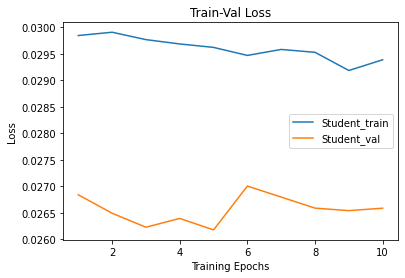

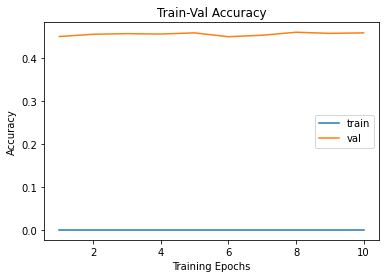

In [ ]:
# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_history['train'], label='Student_train')
plt.plot(range(1, num_epochs+1), loss_history['val'], label='Student_val')

plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_history['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_history['val'], label='val')

plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()


#My KD

In [ ]:
Teacher.load_state_dict(torch.load(T_PATH))
Student.load_state_dict(torch.load(S_PATH))

Teacher.eval()
Student.eval()

In [ ]:

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(Student_opt, mode='min', factor=0.1, patience=10)

num_epochs= 10

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

T_loss_history={'train': [], 'val': []}
T_metric_history={'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = config['SGD_lr']
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    Student2.train()
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(trainloader.dataset)

    for xb, yb in trainloader:
        xb = xb.to(device)
        yb = yb.to(device)

        output = Student2(xb)
        teacher_output = Teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=Student_opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    Student2.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(Student2, loss_func, testloader)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    lr_scheduler.step(val_loss)
    print('Teacher->Student')
    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('')


    ## student -> Teacher

    Teacher.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(trainloader.dataset)
    for xb, yb in trainloader:
        xb = xb.to(device)
        yb = yb.to(device)

        output = Teacher(xb)
        student_output = Student2(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, student_output, loss_fn=distillation, opt=Student_opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    T_loss_history['train'].append(train_loss)
    T_metric_history['train'].append(train_metric)

    # validation
    Teacher.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(Teacher, loss_func, testloader)
    T_loss_history['val'].append(val_loss)
    T_metric_history['val'].append(val_metric)

    lr_scheduler.step(val_loss)
    print('Student->Teacher')
    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

In [ ]:
# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_history['train'], label='Student_train')
plt.plot(range(1, num_epochs+1), loss_history['val'], label='Student_val')

plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_history['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_history['val'], label='val')

plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

plt.title('Teacher Train-Val Loss')
plt.plot(range(1, num_epochs+1), T_loss_history['train'], label='Teacher_train')
plt.plot(range(1, num_epochs+1), T_loss_history['val'], label='Teacher_val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

plt.title('Teacher Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), T_metric_history['train'], label='Teacher_train')
plt.plot(range(1, num_epochs+1), T_metric_history['val'], label='Teacher_val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

#TAKD

In [ ]:
#Teacher=Teacher().to(device)
#Student=Student().to(device)

Teacher.load_state_dict(torch.load(T_PATH))
Student.load_state_dict(torch.load(S_PATH))

Teacher.eval()
Student.eval()

Student(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
class TrainManager(object):
	def __init__(self, student, teacher=None, train_loader=None, test_loader=None, train_config={}):
		self.student = student
		self.teacher = teacher
		self.have_teacher = bool(self.teacher)
		self.device = device
		self.name=student.__class__.__name__
		self.optimizer = optim.SGD(self.student.parameters(),
								   lr=train_config['SGD_lr'],
								   momentum=train_config['momentum'],
								   weight_decay=train_config['wd_decay'])
		if self.have_teacher:
			self.teacher.eval()
			self.teacher.train(mode=False)
			
		self.train_loader = train_loader
		self.test_loader = test_loader
		self.config = train_config
		self.loss_history = {'train': [], 'val': []}
		self.metric_history = {'train': [], 'val': []}

		self.T_loss_history={'train': [], 'val': []}
		self.T_metric_history={'train': [], 'val': []}

	def train(self):
		lambda_ = self.config['lambda']
		T = self.config['T']
		epochs = 5

		
		max_val_acc = 0
		iteration = 0
		best_acc = 0
		criterion = nn.CrossEntropyLoss()
	
    
		for epoch in range(epochs):
			self.student.train()

			running_loss = 0.0
			running_metric=0.0
			len_data = len(trainloader.dataset)
			for xb,yb in trainloader:
				xb = xb.to(device)
				yb = yb.to(device)
				
				output = self.student(xb)
				teacher_output = self.teacher(xb).detach()
				loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=Student_opt)
				running_loss += loss_b
				running_metric_b = metric_b

			train_loss = running_loss / len_data
			train_metric = running_metric / len_data
			self.loss_history['train'].append(train_loss)
			self.metric_history['train'].append(train_metric)



			self.student.eval()
			with torch.no_grad():
				val_loss, val_metric = loss_epoch(self.student, loss_func, testloader)
			self.loss_history['val'].append(val_loss)
			self.metric_history['val'].append(val_metric)
	 

			print('Teacher->Student')
			print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
			print('')
		 
			## student -> Teacher
			self.teacher.train()
			loss = 0
			running_loss = 0.0
			running_metric=0.0
			correct = 0
			total = 0
			acc = 0

			running_loss = 0.0
			running_metric=0.0
			len_data = len(trainloader.dataset)
			for xb,yb in trainloader:
				xb = xb.to(device)
				yb = yb.to(device)
				
				output = self.teacher(xb)
				student_output = self.student(xb).detach()
				loss_b, metric_b = distill_loss_batch(output, yb, student_output, loss_fn=distillation, opt=Student_opt)
				running_loss += loss_b
				running_metric_b = metric_b
			train_loss = running_loss / len_data
			train_metric = running_metric / len_data
			self.T_loss_history['train'].append(train_loss)
			self.T_metric_history['train'].append(train_metric)

			self.teacher.eval()
			with torch.no_grad():
				val_loss, val_metric = loss_epoch(self.teacher, loss_func, testloader)
			self.T_loss_history['val'].append(val_loss)
			self.T_metric_history['val'].append(val_metric)
			print('Student->Teacher')
			print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
			print('-'*10)

	 

			print("epoch {}/{}".format(epoch, epochs))
			val_acc = self.validate(step=epoch)
			if val_acc > best_acc:
				best_acc = val_acc
			
		return best_acc
	
	def validate(self, step=0):
		self.student.eval()
		with torch.no_grad():
			val_loss, val_metric = loss_epoch(self.student, loss_func, testloader)

			print('{{"metric": "{}_val_accuracy", "value": {}}}'.format(self.name, val_metric))
			return val_metric
		
	def model(self):
		return self.student

	def history(self,opt):
		if opt == 's':
			graph(self.loss_history,self.metric_history)
		else:
		 	graph(self.T_loss_history,self.T_metric_history)



In [ ]:
start_time=time.time()

TM1=TrainManager(TA_8,Teacher,trainloader,testloader,config)
TM1.train()

TA_8=TM1.model()


NameError: ignored

In [ ]:
TM2=TrainManager(TA_6,TA_8,trainloader,testloader,config)
TM2.train()


In [ ]:

TA_6=TM2.model()

TM3=TrainManager(TA_4,TA_6,trainloader,testloader,config)
TM3.train()


In [ ]:

TA_4=TM3.model()

TM4=TrainManager(Student,TA_4,trainloader,testloader,config)
TM4.train()
